In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [3]:
colunas = ["NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC","NU_NOTA_MT","NU_NOTA_REDACAO","Q006"]
df = pd.read_csv('enem/Microdados Enem 2017/DADOS/MICRODADOS_ENEM.csv', encoding = 'ISO-8859-1',sep = ';',usecols = colunas)
df.describe()
df = df.dropna()

In [4]:
class_ibge = {"A": ["Q"]
                        ,"B": ["N","O","P"]
                        ,"C":["H","I","J","K","L","M"]
                        ,"D":["E","F","G"]
                        ,"E":["A","B","C","D"]}

def get_key(val):
    for keyvalue in list(class_ibge.items()):
        if val in keyvalue[1]:
            return keyvalue[0]



df["CLASSE_IBGE"] = df["Q006"].apply(get_key)
df.groupby("CLASSE_IBGE").count()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q006
CLASSE_IBGE,,,,,,
A,48557,48557,48557,48557,48557,48557
B,122851,122851,122851,122851,122851,122851
C,542192,542192,542192,542192,542192,542192
D,869379,869379,869379,869379,869379,869379
E,2843775,2843775,2843775,2843775,2843775,2843775


NU_NOTA_CN: média A,B: 594.26 
NU_NOTA_CN: média C,D,E: 507.57
NU_NOTA_CH: média A,B: 609.32 
NU_NOTA_CH: média C,D,E: 517.91
NU_NOTA_LC: média A,B: 579.20 
NU_NOTA_LC: média C,D,E: 509.45
NU_NOTA_MT: média A,B: 651.96 
NU_NOTA_MT: média C,D,E: 513.47


ValueError: num must be 1 <= num <= 4, not 5

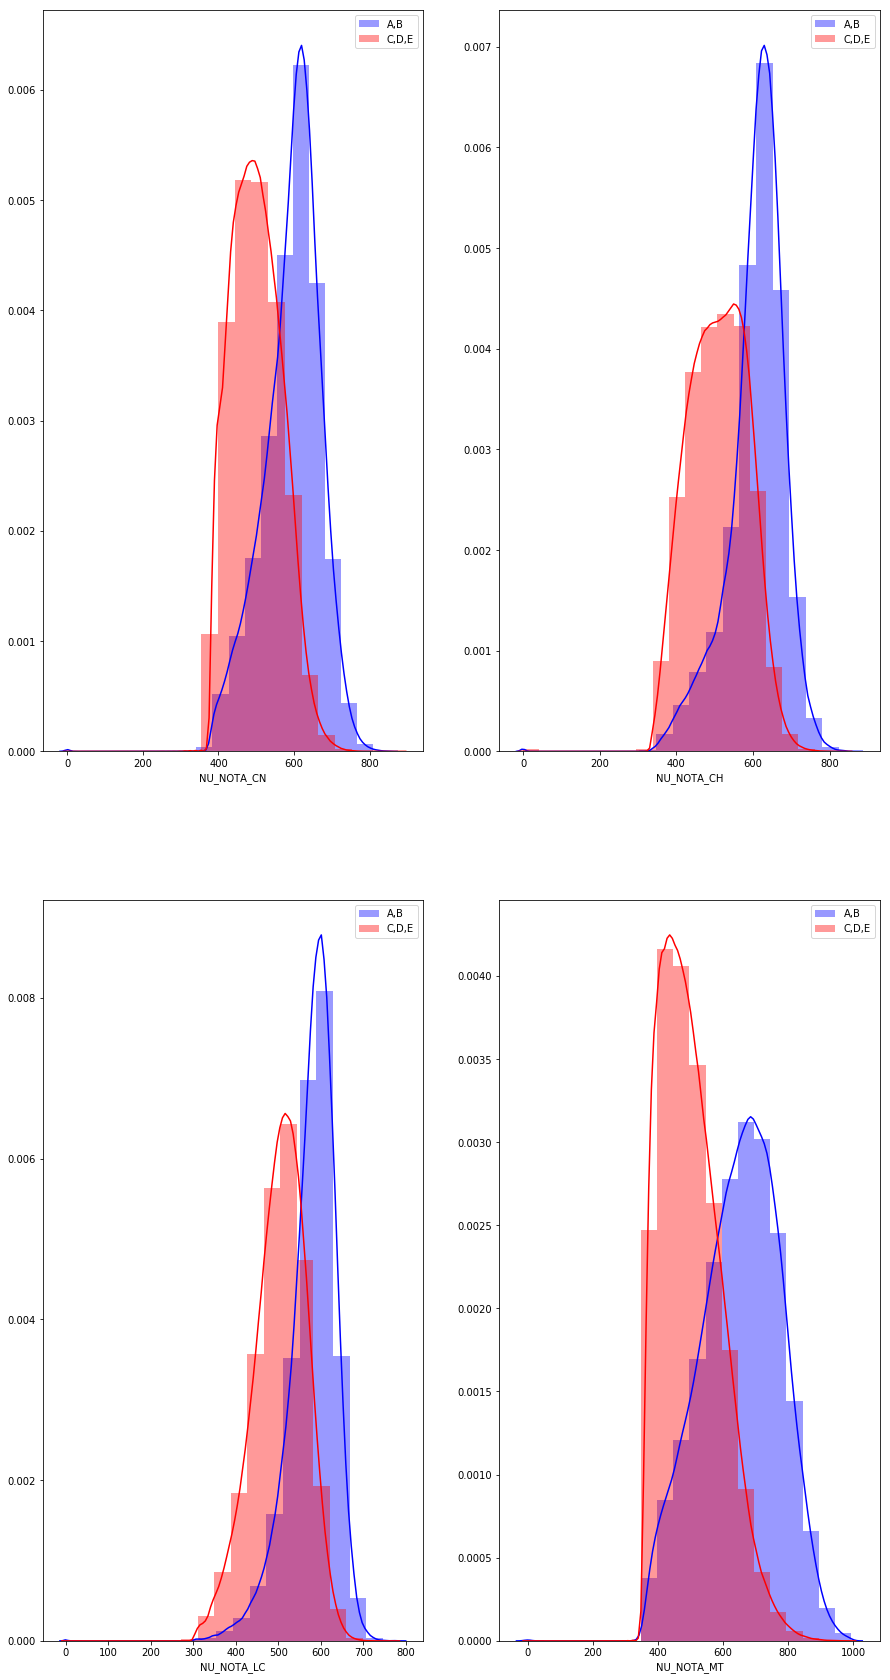

In [46]:
## classes sociais
notas =["NU_NOTA_CN","NU_NOTA_CH","NU_NOTA_LC","NU_NOTA_MT","NU_NOTA_REDACAO"]
dfnotas = df[notas]

df_AB = df[(df["CLASSE_IBGE"] == "A")|(df["CLASSE_IBGE"] == 'B')]
df_CDE = df[(df["CLASSE_IBGE"] == "E")|(df["CLASSE_IBGE"] == 'D') | (df['CLASSE_IBGE'] == 'C')]
bins = 20
plt.figure(figsize=(15,30))
rows = 3 
for i, col in enumerate(notas):
    plt.subplot(rows, 2, i+1)
    sns.distplot(df_A[col], bins=bins, color='blue', label='A,B');
    sns.distplot(df_E[col], bins=bins, color='red', label='C,D,E');
    plt.legend(loc='upper right')
    print("{}: média A,B: {:.2f} ".format(col, df_AB[col].mean()))
    print("{}: média C,D,E: {:.2f}".format(col, df_CDE[col].mean()))


plt.show()



In [37]:
## classificação

df_clean = df.replace({'CLASSE_IBGE':{'A':1,'B':1,'C':0,'D':0,'E':0}})

df_ab = df_clean[(df_clean['CLASSE_IBGE'] == 1)].sample(150000, random_state = 0)
df_cde = df_clean[(df_clean['CLASSE_IBGE'] == 0)].sample(150000,random_state = 0)

df_clean = pd.concat([df_ab,df_cde], axis = 0)

X = df_clean[notas]
Y = df_clean.loc[:,"CLASSE_IBGE"]

X_1, X_2, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

scaler = preprocessing.StandardScaler().fit(X_1)

X_train = scaler.transform(X_1)
X_test = scaler.transform(X_2)


In [39]:
param = {"n_neighbors" : list(range(30,35))}

grid = GridSearchCV(KNeighborsClassifier(n_neighbors = 5), param, scoring = "accuracy",cv = 5, n_jobs = -1)

grid.fit (X_1,y_train)

print("Melhor parâmetro: {} ".format(grid.best_params_))
print("Melhor score: {}".format(grid.best_score_))

print("Acurácia no conjunto de teste: {}".format(accuracy_score(y_test,grid.predict(X_2))))

print(classification_report(y_test,grid.predict(X_2), target_names = ["C,D,E","A,B"]))

Melhor parâmetro: {'n_neighbors': 31} 
Melhor score: 0.7720088888888889
Acurácia no conjunto de teste: 0.7722
              precision    recall  f1-score   support

       C,D,E       0.77      0.78      0.77     37378
         A,B       0.78      0.77      0.77     37622

   micro avg       0.77      0.77      0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



In [38]:
logi = LogisticRegressionCV(fit_intercept = True, scoring = 'accuracy', cv = 5, random_state = 0)

logi.fit(X_1, y_train)

print("Acurácia regressão logistica no conjunto de teste: {}".format(logi.score(X_2,y_test)))
print("Coeficientes regressão logística: {}".format(logi.coef_))
print("Intersecção regressão logística: {}".format(logi.intercept_))

print(classification_report(y_test,logi.predict(X_2), target_names = ["C,D,E","A,B"]))

Acurácia regressão logistica no conjunto de teste: 0.77356
Coeficientes regressão logística: [[0.00540924 0.00246815 0.00543008 0.00485444 0.00154132]]
              precision    recall  f1-score   support

       C,D,E       0.77      0.78      0.77     37378
         A,B       0.78      0.77      0.77     37622

   micro avg       0.77      0.77      0.77     75000
   macro avg       0.77      0.77      0.77     75000
weighted avg       0.77      0.77      0.77     75000



/home/vinicius/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1926: ChangedBehaviorWarning: The long-standing behavior to use the accuracy score has changed. The scoring parameter is now used. This warning will disappear in version 0.22.
  ChangedBehaviorWarning)


In [51]:
teste = np.array([[400,400,400,400,400],
                                  [500,500,500,500,500],
                                  [600,600,600,600,600],
                                  [700,700,700,700,700],
                                  [800,800,800,800,800]])

prob = logi.predict_proba(teste)


print(" Probabilidades para notas uniformes: \n 400: {} \n 500: {}  \n 600: {} \n 700: {} \n 800: {}".format(prob[0],prob[1],prob[2],prob[3],prob[4]))

Intersecção regressão logística: [-11.06444579]
 Probabilidades para notas uniformes: 
 400: [0.96019551 0.03980449] 
 500: [0.77080017 0.22919983]  
 600: [0.31919206 0.68080794] 
 700: [0.06135219 0.93864781] 
 800: [0.00903 0.99097]
